## Benchmarks and Verifiers

In [47]:
import joblib
import ast
import itertools
import json
import numpy as np
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from create_feature import get_kwcounts, get_bitcounts
from parse_raw_tsv import parse_from_tsv, parse_from_tsv_lst, get_btor2path_from_yml, tsv_train_test_partition
from pairwise_model import PairwiseXGBoost, get_pw_algorithm_selection_lst
from ehm import get_ehm_algorithm_selection_lst
from analyze import get_par_N_for_dict, get_solved_num_for_dict, generate_one_resdict, generate_vbs_resdict, get_sbs


In [2]:
all_res_tsv = "performance_data/performance.table.csv"
all_res_dict, tool_config_dict = parse_from_tsv(all_res_tsv, num_tool_cols=2, timeout=900.0)
tool_config_size = len(tool_config_dict)
print("Total number of benchmarks:", len(all_res_dict))
print("Total number of tools:", tool_config_size)

Total number of benchmarks: 1441
Total number of tools: 10


In [3]:
# print component verifier list
tool_config_dict

{0: ('ESBMC version 7.4.0 64-bit x86_64 linux', 'esbmc.kind.bv64'),
 1: ('ESBMC version 7.4.0 64-bit x86_64 linux', 'esbmc.bmc-5-boolector.bv64'),
 2: ('AVR ', 'avr.kind.bv64'),
 3: ('AVR ', 'avr.pdr.bv64'),
 4: ('ABC 1.01 (compiled Jun  7 2024 14:12:22)', 'abc.pdr.bv64'),
 5: ('ABC 1.01 (compiled Jun  7 2024 14:12:22)', 'abc.imc.bv64'),
 6: ('AVR ', 'avr.bmc-boolector.bv64'),
 7: ('CBMC 5.95.1 (n/a)', 'cbmc.bmc.bv64'),
 8: ('ABC 1.01 (compiled Jun  7 2024 14:12:22)', 'abc.bmc.bv64'),
 9: ('CBMC 5.95.1 (n/a)', 'cbmc.kind.bv64')}

## Training & Testing Set

In [4]:
# divide data into training-testing ratio of 4:1
tsv_train_test_partition('performance_data/performance.table.csv', 4, 'bv_data/', random_seed=42)

/Users/zhengyanglu/opt/anaconda3/envs/btor2select/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
training_res_tsv = "bv_data/train.tsv"
training_res_dict, _ = parse_from_tsv(training_res_tsv, num_tool_cols=2, timeout=900.0)
test_res_tsv = "bv_data/test.tsv"
test_res_dict, _ = parse_from_tsv(test_res_tsv, num_tool_cols=2, timeout=900.0)
print(f"Trainng instance set size: {len(training_res_dict)}")
print(f"Test instance set size: {len(test_res_dict)}")

Trainng instance set size: 1153
Test instance set size: 288


### Test set SBS and VBS

In [51]:
dict_par2_func = partial(get_par_N_for_dict, N=2, timeout=900.0)

vbs_test_resdict = generate_vbs_resdict(test_res_dict)
vbs_test_par2 = get_par_N_for_dict(vbs_test_resdict, 2, 900.0)
vbs_test_solved = get_solved_num_for_dict(vbs_test_resdict)

sbs_config = get_sbs(test_res_dict, dict_par2_func)
sbs_resdict = generate_one_resdict(test_res_dict, sbs_config)
sbs_test_par2 = dict_par2_func(sbs_resdict)
sbs_test_solved = get_solved_num_for_dict(sbs_resdict)
print(f"VBS: Par2: {vbs_test_par2:.1f}, Solved: {vbs_test_solved}")
print(f"SBS: Par2: {sbs_test_par2:.1f}, Solved: {sbs_test_solved}\n")

# print each tool's performance
individual_tool_performance_strs = []
for tool_id in range(tool_config_size):
    tool_resdict = generate_one_resdict(test_res_dict, tool_id)
    tool_par2 = dict_par2_func(tool_resdict)
    tool_solved = get_solved_num_for_dict(tool_resdict)
    tool_name = tool_config_dict[tool_id][1]
    individual_tool_performance_strs.append(f"{tool_name}: Par2: {tool_par2:.1f}, Solved: {tool_solved}")

# sort performance_strs
individual_tool_performance_strs.sort()
for s in individual_tool_performance_strs:
    print(s)

VBS: Par2: 96629.8, Solved: 239
SBS: Par2: 166683.4, Solved: 201

abc.bmc.bv64: Par2: 384379.0, Solved: 76
abc.imc.bv64: Par2: 274126.7, Solved: 141
abc.pdr.bv64: Par2: 166683.4, Solved: 201
avr.bmc-boolector.bv64: Par2: 381769.1, Solved: 78
avr.kind.bv64: Par2: 327324.0, Solved: 107
avr.pdr.bv64: Par2: 241999.9, Solved: 159
cbmc.bmc.bv64: Par2: 353878.0, Solved: 94
cbmc.kind.bv64: Par2: 281047.6, Solved: 136
esbmc.bmc-5-boolector.bv64: Par2: 369753.8, Solved: 85
esbmc.kind.bv64: Par2: 326327.7, Solved: 109


## Instance Embedding
BoKW and BWA for 69 keywords

In [7]:
from create_feature import KEYWORDS
print(f"The list of all keywords (in total {len(KEYWORDS)}) are")
print(KEYWORDS)

The list of all keywords (in total 69) are
['add', 'and', 'bad', 'constraint', 'concat', 'const', 'constd', 'consth', 'dec', 'eq', 'fair', 'iff', 'implies', 'iff', 'inc', 'init', 'input', 'ite', 'justice', 'mul', 'nand', 'neq', 'neg', 'next', 'nor', 'not', 'one', 'ones', 'or', 'output', 'read', 'redand', 'redor', 'redxor', 'rol', 'ror', 'saddo', 'sext', 'sgt', 'sgte', 'sdiv', 'sdivo', 'slice', 'sll', 'slt', 'slte', 'sort', 'smod', 'smulo', 'ssubo', 'sra', 'srl', 'srem', 'state', 'sub', 'uaddo', 'udiv', 'uext', 'ugt', 'ugte', 'ult', 'ulte', 'umulo', 'urem', 'usubo', 'write', 'xnor', 'xor', 'zero']


## Parwise Models
### BoKW

To retrain the models, run the following script:

```bash
python pairwise_model.py --save_dir=saved_models/pw_bokw bv_data/train.tsv
```

In [8]:
pw_bokw_dir = "saved_models/pw_bokw"
pw_bokw_xg_matrix = np.empty((tool_config_size, tool_config_size), dtype=object)
pw_bokw_xg_matrix[:] = None
for i in range(tool_config_size):
    for j in range(i+1, tool_config_size):
        pw_bokw_xg_matrix[i, j] = joblib.load(Path(pw_bokw_dir) / f"xg_{i}_{j}.joblib")

In [9]:
pw_bokw_res = {}
for test_benchmark in test_res_dict:
    selected_lst = get_pw_algorithm_selection_lst(test_benchmark, pw_bokw_xg_matrix, get_kwcounts)
    selected_config = selected_lst[0]
    selected_config_name = tool_config_dict[selected_config][1]
    # print(f"Selected config {selected_config_name} for {test_benchmark}")
    res_tuple = test_res_dict[test_benchmark][selected_config]
    pw_bokw_res[test_benchmark] = res_tuple

In [10]:
pw_bokw_par2 = get_par_N_for_dict(pw_bokw_res, 2, 900.0)
pw_bokw_solved = get_solved_num_for_dict(pw_bokw_res)
print(f"Pairwise model with BoKW: Par2: {pw_bokw_par2:.1f}, Solved: {pw_bokw_solved}")
print(f"Closed VBS-SBS gap: {(sbs_test_par2 - pw_bokw_par2)/(sbs_test_par2 - vbs_test_par2)*100:.2f}%")

Pairwise model with BoKW: Par2: 120484.8, Solved: 227
Closed VBS-SBS gap: 65.95%


### BoKW with PCA
Training script:
```bash
python pairwise_model.py --pca --save_dir=saved_models/pw_bokw_pca bv_data/train.tsv
```

In [11]:
pw_bokw_pca_dir = "saved_models/pw_bokw_pca"
pw_bokw_pca_xg_matrix = np.empty((tool_config_size, tool_config_size), dtype=object)
pw_bokw_pca_scaler_matrix = np.empty((tool_config_size, tool_config_size), dtype=object)
pw_bokw_pca_pca_matrix = np.empty((tool_config_size, tool_config_size), dtype=object)
pw_bokw_pca_xg_matrix[:] = None
pw_bokw_pca_scaler_matrix[:] = None
pw_bokw_pca_pca_matrix[:] = None
for i in range(tool_config_size):
    for j in range(i+1, tool_config_size):
        pw_bokw_pca_xg_matrix[i, j] = joblib.load(Path(pw_bokw_pca_dir) / f"xg_{i}_{j}.joblib")
        pw_bokw_pca_scaler_matrix[i, j] = joblib.load(Path(pw_bokw_pca_dir) / f"scaler_{i}_{j}.joblib")
        pw_bokw_pca_pca_matrix[i, j] = joblib.load(Path(pw_bokw_pca_dir) / f"pca_{i}_{j}.joblib")

In [12]:
pw_bokw_pca_res = {}
for test_benchmark in test_res_dict:
    selected_lst = get_pw_algorithm_selection_lst(test_benchmark, pw_bokw_pca_xg_matrix, get_kwcounts, scaler_matrix=pw_bokw_pca_scaler_matrix, pca_matrix=pw_bokw_pca_pca_matrix)
    selected_config = selected_lst[0]
    selected_config_name = tool_config_dict[selected_config][1]
    # print(f"Selected config {selected_config_name} for {test_benchmark}")
    res_tuple = test_res_dict[test_benchmark][selected_config]
    pw_bokw_pca_res[test_benchmark] = res_tuple

In [13]:
pw_bokw_pca_par2 = get_par_N_for_dict(pw_bokw_pca_res, 2, 900.0)
pw_bokw_pca_solved = get_solved_num_for_dict(pw_bokw_pca_res)
print(f"Pairwise model with BoKW PCA: Par2: {pw_bokw_pca_par2:.1f}, Solved: {pw_bokw_pca_solved}")
print(f"Closed VBS-SBS gap: {(sbs_test_par2 - pw_bokw_pca_par2)/(sbs_test_par2 - vbs_test_par2)*100:.2f}%")

Pairwise model with BoKW PCA: Par2: 125330.9, Solved: 224
Closed VBS-SBS gap: 59.03%


### BWA
Training script:

```bash
python pairwise_model.py --save_dir=saved_models/pw_bwa --bit bv_data/train.tsv
```

In [14]:
pw_bwa_dir = "saved_models/pw_bwa"
pw_bwa_xg_matrix = np.empty((tool_config_size, tool_config_size), dtype=object)
pw_bwa_xg_matrix[:] = None
for i in range(tool_config_size):
    for j in range(i+1, tool_config_size):
        pw_bwa_xg_matrix[i, j] = joblib.load(Path(pw_bwa_dir) / f"xg_{i}_{j}.joblib")
pw_bwa_res = {}
for test_benchmark in test_res_dict:
    selected_lst = get_pw_algorithm_selection_lst(test_benchmark, pw_bwa_xg_matrix, get_bitcounts)
    selected_config = selected_lst[0]
    selected_config_name = tool_config_dict[selected_config][1]
    # print(f"Selected config {selected_config_name} for {test_benchmark}")
    res_tuple = test_res_dict[test_benchmark][selected_config]
    pw_bwa_res[test_benchmark] = res_tuple

In [15]:
pw_bwa_par2 = get_par_N_for_dict(pw_bwa_res, 2, 900.0)
pw_bwa_solved = get_solved_num_for_dict(pw_bwa_res)
print(f"Pairwise model with BWA: Par2: {pw_bwa_par2:.1f}, Solved: {pw_bwa_solved}")
print(f"Closed VBS-SBS gap: {(sbs_test_par2 - pw_bwa_par2)/(sbs_test_par2 - vbs_test_par2)*100:.2f}%")

Pairwise model with BWA: Par2: 122008.9, Solved: 226
Closed VBS-SBS gap: 63.77%


### BWA with PCA
Training script:
```bash
python pairwise_model.py --save_dir=saved_models/pw_bwa_pca --bit --pca bv_data/train.tsv
```

In [23]:
pw_bwa_pca_dir = "saved_models/pw_bwa_pca"
pw_bwa_pca_xg_matrix = np.empty((tool_config_size, tool_config_size), dtype=object)
pw_bwa_pca_scaler_matrix = np.empty((tool_config_size, tool_config_size), dtype=object)
pw_bwa_pca_pca_matrix = np.empty((tool_config_size, tool_config_size), dtype=object)
pw_bwa_pca_xg_matrix[:] = None
pw_bwa_pca_scaler_matrix[:] = None
pw_bwa_pca_pca_matrix[:] = None
for i in range(tool_config_size):
    for j in range(i+1, tool_config_size):
        pw_bwa_pca_xg_matrix[i, j] = joblib.load(Path(pw_bwa_pca_dir) / f"xg_{i}_{j}.joblib")
        pw_bwa_pca_scaler_matrix[i, j] = joblib.load(Path(pw_bwa_pca_dir) / f"scaler_{i}_{j}.joblib")
        pw_bwa_pca_pca_matrix[i, j] = joblib.load(Path(pw_bwa_pca_dir) / f"pca_{i}_{j}.joblib")
pw_bwa_pca_res = {}
for test_benchmark in test_res_dict:
    selected_lst = get_pw_algorithm_selection_lst(test_benchmark, pw_bwa_pca_xg_matrix, get_bitcounts, scaler_matrix=pw_bwa_pca_scaler_matrix, pca_matrix=pw_bwa_pca_pca_matrix)
    selected_config = selected_lst[0]
    selected_config_name = tool_config_dict[selected_config][1]
    # print(f"Selected config {selected_config_name} for {test_benchmark}")
    res_tuple = test_res_dict[test_benchmark][selected_config]
    pw_bwa_pca_res[test_benchmark] = res_tuple
pw_bwa_pca_par2 = get_par_N_for_dict(pw_bwa_pca_res, 2, 900.0)
pw_bwa_pca_solved = get_solved_num_for_dict(pw_bwa_pca_res)
print(f"Pairwise model with BWA PCA: Par2: {pw_bwa_pca_par2:.1f}, Solved: {pw_bwa_pca_solved}")
print(f"Closed VBS-SBS gap: {(sbs_test_par2 - pw_bwa_pca_par2)/(sbs_test_par2 - vbs_test_par2)*100:.2f}%")

Pairwise model with BWA PCA: Par2: 128951.6, Solved: 222
Closed VBS-SBS gap: 53.86%


## EHM Models
### BoKW
Training script:
```bash
python ehm.py --save_dir=saved_models/ehm_bokw bv_data/train.tsv
```

In [16]:
# Load the xg regressor models
ehm_bokw_dir = "saved_models/ehm_bokw"
ehm_bokw_regressors = []
for i in range(tool_config_size):
    model = XGBRegressor()
    model.load_model(f"{ehm_bokw_dir}/xg_{i}.json")
    ehm_bokw_regressors.append(model)

In [17]:
ehm_bokw_res = {}
for benchmark in test_res_dict:
    selected_lst = get_ehm_algorithm_selection_lst(benchmark, ehm_bokw_regressors, get_kwcounts)
    selected_config = selected_lst[0]
    selected_config_name = tool_config_dict[selected_config][1]
    # print(f"Selected config {selected_config_name} for {benchmark}")
    res_tuple = test_res_dict[benchmark][selected_config]
    ehm_bokw_res[benchmark] = res_tuple
    

In [18]:
ehm_bokw_par2 = get_par_N_for_dict(ehm_bokw_res, 2, 900.0)
ehm_bokw_solved = get_solved_num_for_dict(ehm_bokw_res)
print(f"EHM model with BoKW: Par2: {ehm_bokw_par2:.1f}, Solved: {ehm_bokw_solved}")
print(f"Closed VBS-SBS gap: {(sbs_test_par2 - ehm_bokw_par2)/(sbs_test_par2 - vbs_test_par2)*100:.2f}%")

EHM model with BoKW: Par2: 123815.0, Solved: 226
Closed VBS-SBS gap: 61.19%


### BoKW with PCA
Training script:
```bash
python ehm.py --save_dir=saved_models/ehm_bokw --pca bv_data/train.tsv
```

In [19]:
ehm_bokw_pca_dir = "saved_models/ehm_bokw_pca"
ehm_bokw_pca_regressors = []
ehm_bokw_pca_scalers = []
ehm_bokw_pca_pcas = []
for i in range(tool_config_size):
    model = XGBRegressor()
    model.load_model(f"{ehm_bokw_pca_dir}/xg_{i}.json")
    ehm_bokw_pca_regressors.append(model)
    scaler = StandardScaler()
    scaler_path = f"{ehm_bokw_pca_dir}/scaler_{i}.joblib"
    scaler = joblib.load(scaler_path)
    ehm_bokw_pca_scalers.append(scaler)
    pca = PCA()
    pca_path = f"{ehm_bokw_pca_dir}/pca_{i}.joblib"
    pca = joblib.load(pca_path)
    ehm_bokw_pca_pcas.append(pca)

In [20]:
ehm_bokw_pca_res = {}
for benchmark in test_res_dict:
    selected_lst = get_ehm_algorithm_selection_lst(benchmark, ehm_bokw_pca_regressors, get_kwcounts, scalers=ehm_bokw_pca_scalers, pcas=ehm_bokw_pca_pcas)
    selected_config = selected_lst[0]
    selected_config_name = tool_config_dict[selected_config][1]
    # print(f"Selected config {selected_config_name} for {benchmark}")
    res_tuple = test_res_dict[benchmark][selected_config]
    ehm_bokw_pca_res[benchmark] = res_tuple
ehm_bokw_pca_par2 = get_par_N_for_dict(ehm_bokw_pca_res, 2, 900.0)
ehm_bokw_pca_solved = get_solved_num_for_dict(ehm_bokw_pca_res)
print(f"EHM model with BoKW and PCA: Par2: {ehm_bokw_pca_par2:.1f}, Solved: {ehm_bokw_pca_solved}")
print(f"Closed VBS-SBS gap: {(sbs_test_par2 - ehm_bokw_pca_par2)/(sbs_test_par2 - vbs_test_par2)*100:.2f}%")

EHM model with BoKW and PCA: Par2: 128566.8, Solved: 222
Closed VBS-SBS gap: 54.41%


### BWA
Training script
```bash
python ehm.py --save_dir=saved_models/ehm_bwa --bit bv_data/train.tsv
```

In [21]:
ehm_bwa_dir = "saved_models/ehm_bwa"
ehm_bwa_regressors = []
for i in range(tool_config_size):
    model = XGBRegressor()
    model.load_model(f"{ehm_bwa_dir}/xg_{i}.json")
    ehm_bwa_regressors.append(model)
ehm_bwa_res = {}
for benchmark in test_res_dict:
    selected_lst = get_ehm_algorithm_selection_lst(benchmark, ehm_bwa_regressors, get_bitcounts)
    selected_config = selected_lst[0]
    selected_config_name = tool_config_dict[selected_config][1]
    # print(f"Selected config {selected_config_name} for {benchmark}")
    res_tuple = test_res_dict[benchmark][selected_config]
    ehm_bwa_res[benchmark] = res_tuple

In [22]:
ehm_bwa_par2 = get_par_N_for_dict(ehm_bwa_res, 2, 900.0)
ehm_bwa_solved = get_solved_num_for_dict(ehm_bwa_res)
print(f"EHM model with BWA: Par2: {ehm_bwa_par2:.1f}, Solved: {ehm_bwa_solved}")
print(f"Closed VBS-SBS gap: {(sbs_test_par2 - ehm_bwa_par2)/(sbs_test_par2 - vbs_test_par2)*100:.2f}%")

EHM model with BWA: Par2: 128188.4, Solved: 223
Closed VBS-SBS gap: 54.95%


### BWA with PCA
Training script
```bash
python ehm.py --save_dir=saved_models/ehm_bwa_pca --bit --pca bv_data/train.tsv
```

In [24]:
ehm_bwa_pca_dir = "saved_models/ehm_bwa_pca"
ehm_bwa_pca_regressors = []
ehm_bwa_pca_scalers = []
ehm_bwa_pca_pcas = []
for i in range(tool_config_size):
    model = XGBRegressor()
    model.load_model(f"{ehm_bwa_pca_dir}/xg_{i}.json")
    ehm_bwa_pca_regressors.append(model)
    scaler = StandardScaler()
    scaler_path = f"{ehm_bwa_pca_dir}/scaler_{i}.joblib"
    scaler = joblib.load(scaler_path)
    ehm_bwa_pca_scalers.append(scaler)
    pca = PCA()
    pca_path = f"{ehm_bwa_pca_dir}/pca_{i}.joblib"
    pca = joblib.load(pca_path)
    ehm_bwa_pca_pcas.append(pca)
ehm_bwa_pca_res = {}
for benchmark in test_res_dict:
    selected_lst = get_ehm_algorithm_selection_lst(benchmark, ehm_bwa_pca_regressors, get_bitcounts, scalers=ehm_bwa_pca_scalers, pcas=ehm_bwa_pca_pcas)
    selected_config = selected_lst[0]
    selected_config_name = tool_config_dict[selected_config][1]
    # print(f"Selected config {selected_config_name} for {benchmark}")
    res_tuple = test_res_dict[benchmark][selected_config]
    ehm_bwa_pca_res[benchmark] = res_tuple
ehm_bwa_pca_par2 = get_par_N_for_dict(ehm_bwa_pca_res, 2, 900.0)
ehm_bwa_pca_solved = get_solved_num_for_dict(ehm_bwa_pca_res)
print(f"EHM model with BWA and PCA: Par2: {ehm_bwa_pca_par2:.1f}, Solved: {ehm_bwa_pca_solved}")
print(f"Closed VBS-SBS gap: {(sbs_test_par2 - ehm_bwa_pca_par2)/(sbs_test_par2 - vbs_test_par2)*100:.2f}%")

EHM model with BWA and PCA: Par2: 135361.1, Solved: 219
Closed VBS-SBS gap: 44.71%


## Contribution Analysis

In [25]:
tool_config_dict

{0: ('ESBMC version 7.4.0 64-bit x86_64 linux', 'esbmc.kind.bv64'),
 1: ('ESBMC version 7.4.0 64-bit x86_64 linux', 'esbmc.bmc-5-boolector.bv64'),
 2: ('AVR ', 'avr.kind.bv64'),
 3: ('AVR ', 'avr.pdr.bv64'),
 4: ('ABC 1.01 (compiled Jun  7 2024 14:12:22)', 'abc.pdr.bv64'),
 5: ('ABC 1.01 (compiled Jun  7 2024 14:12:22)', 'abc.imc.bv64'),
 6: ('AVR ', 'avr.bmc-boolector.bv64'),
 7: ('CBMC 5.95.1 (n/a)', 'cbmc.bmc.bv64'),
 8: ('ABC 1.01 (compiled Jun  7 2024 14:12:22)', 'abc.bmc.bv64'),
 9: ('CBMC 5.95.1 (n/a)', 'cbmc.kind.bv64')}

In [26]:
software_tool_config_lst = [0, 1, 7, 9]

In [27]:
def evaluate_pw_num_solved(test_res_dict, model_matrix, selected_tool_config_lst, feature_func):
    selected_size = len(selected_tool_config_lst)
    if selected_size == 0: return 0
    elif selected_size == 1:
        selected_config = selected_tool_config_lst[0]
        select_res_dict = generate_one_resdict(test_res_dict, selected_config)
        return get_solved_num_for_dict(select_res_dict)
    else:
        all_tool_config_size = model_matrix.shape[0]
        assert selected_size <= all_tool_config_size
        exclude_lst = [i for i in range(all_tool_config_size) if i not in selected_tool_config_lst]
        select_res_dict = {}
        for test_benchmark in test_res_dict:
            selected_lst = get_pw_algorithm_selection_lst(test_benchmark, model_matrix, feature_func, exclude_lst=exclude_lst)
            selected_config = selected_lst[0]
            res_tuple = test_res_dict[test_benchmark][selected_config]
            select_res_dict[test_benchmark] = res_tuple
        return get_solved_num_for_dict(select_res_dict)

In [32]:
def powerset(tool_config_size):
    tool_configs = list(range(tool_config_size))
    powerset_lst = []
    for i in range(tool_config_size+1):
        for subset in itertools.combinations(tool_configs, i):
            powerset_lst.append(subset)
    return powerset_lst

In [33]:
config_powerset = powerset(tool_config_size)

In [34]:
# pw_bokw_contribution_dataset = {}
# for configs in config_powerset:
#     num_solved = evaluate_pw_num_solved(test_res_dict, pw_bokw_xg_matrix, list(configs), get_kwcounts)
#     pw_bokw_contribution_dataset[configs] = num_solved
# pw_bokw_contribution_dataset_str_keys = {str(k): v for k, v in pw_bokw_contribution_dataset.items()}
# with open("pw_bokw_contribution_dataset.json", "w") as f:
#     json.dump(pw_bokw_contribution_dataset_str_keys, f)

In [40]:
# the above code takes a long time to run, so we save the results in a json file; you can choose to uncomment the above code to run it
with open("pw_bokw_contribution_dataset.json", "r") as f:
    pw_bokw_contribution_dataset_str_keys = json.load(f)
pw_bokw_contribution_dataset = {ast.literal_eval(k): v for k, v in pw_bokw_contribution_dataset_str_keys.items()}

In [42]:
config_lst = list(range(tool_config_size))
permutations = list(itertools.permutations(config_lst))

In [43]:
def get_shapley(tool_config_id, tool_config_size, contribution_dataset):
    permutations = list(itertools.permutations(range(tool_config_size)))
    sum_contribution = 0
    for perm in permutations:
        assert tool_config_id in perm
        index = perm.index(tool_config_id)
        before_perm = perm[:index]
        sorted_before_perm = tuple(sorted(before_perm))
        before_score = contribution_dataset[sorted_before_perm]
        after_perm = perm[:index+1]
        sorted_after_perm = tuple(sorted(after_perm))
        after_score = contribution_dataset[sorted_after_perm]
        contribution = after_score - before_score
        sum_contribution += contribution
    return sum_contribution / len(permutations)

In [45]:
paper_verifier_names =[
    "ESBMC.K-Ind",
    "ESBMC.BMC",
    "AVR.K-Ind",
    "AVR.PDR",
    "ABC.PDR",
    "ABC.IMC",
    "AVR.BMC",
    "CBMC.BMC",
    "ABC.BMC",
    "CBMC.K-Ind"
]

In [46]:
shapley_dict = {}
for i in range(tool_config_size):
    shapley = get_shapley(i, tool_config_size, pw_bokw_contribution_dataset)
    config_name = paper_verifier_names[i]
    shapley_dict[config_name] = shapley
    print(f"Tool config {config_name}: {shapley:.2f}")

Tool config ESBMC.K-Ind: 16.40
Tool config ESBMC.BMC: 9.99
Tool config AVR.K-Ind: 14.24
Tool config AVR.PDR: 40.41
Tool config ABC.PDR: 67.38
Tool config ABC.IMC: 27.94
Tool config AVR.BMC: 8.00
Tool config CBMC.BMC: 12.37
Tool config ABC.BMC: 7.38
Tool config CBMC.K-Ind: 22.89


([<matplotlib.patches.Wedge at 0x16c45e060>,
 [Text(-0.9103607464747735, 0.6174490353688257, 'ABC.BMC'),
  Text(-1.0936988637291558, 0.1175703852062813, 'ABC.IMC'),
  Text(-0.386082274281332, -1.0300196490775089, 'ABC.PDR'),
  Text(0.6956695895628597, -0.8520820513057663, 'AVR.BMC'),
  Text(0.9211336231801357, -0.6012593851633719, 'AVR.K-Ind'),
  Text(1.0826285848425612, 0.19471863619539168, 'AVR.PDR'),
  Text(0.7380557771066889, 0.9461890243917659, 'CBMC.BMC'),
  Text(0.20837737983982868, 1.1817693800277143, 'CBMC.K-Ind'),
  Text(-0.33222206036761603, 1.1530951836709302, 'ESBMC.BMC'),
  Text(-0.7221573806153339, 0.9583781704644572, 'ESBMC.K-Ind')],
 [Text(-0.49656040716805816, 0.33679038292845037, '7.4'),
  Text(-0.5965630165795395, 0.06412930102160797, '27.9'),
  Text(-0.21059033142618108, -0.5618288994968229, '67.4'),
  Text(0.3794561397615598, -0.46477202798496337, '8.0'),
  Text(0.5024365217346194, -0.32795966463456644, '14.2'),
  Text(0.590524682641397, 0.10621016519748637, '40.4

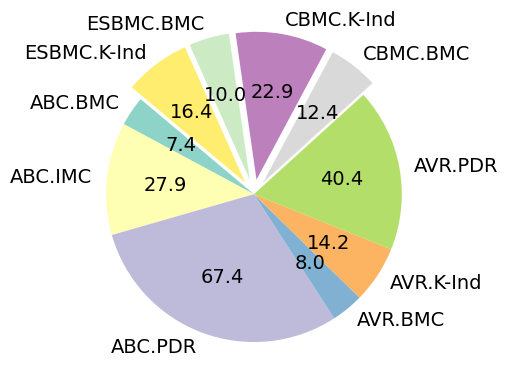

In [52]:
sorted_shapley_dict = dict(sorted(shapley_dict.items()))

labels = list(sorted_shapley_dict.keys())
values = list(sorted_shapley_dict.values())
explode = (0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1)

cmap = plt.get_cmap('Set3')
colors = cmap(np.linspace(0, 1, len(labels)))

plt.pie(values, labels=labels, colors=colors, explode=explode, autopct=lambda p: f'{p * sum(values) / 100 :.1f}', startangle=140, textprops={'fontsize': 14})

In [53]:
sw_shapley_sum = shapley_dict['ESBMC.K-Ind'] + shapley_dict['ESBMC.BMC'] + shapley_dict['CBMC.K-Ind'] + shapley_dict['CBMC.BMC']
# sum of all shapley values in the dict
shapley_sum = sum(shapley_dict.values())
print(f"percentage of software tools: {sw_shapley_sum/shapley_sum*100:.2f}%")

percentage of software tools: 27.16%
